# 07.11 - Modeling - SARIMAX III

## Imports & setup

In [1]:
import pathlib
import warnings
from datetime import datetime
import sys
import pickle
import joblib
import gc

import pandas as pd
import numpy as np

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates


# Imports
sys.path.append("..")
from src.utils.utils import (AnnualTimeSeriesSplit,
                             RollingAnnualTimeSeriesSplit,
                             bound_precision,
                             save_run_results,
                             run_cross_val,
                             run_data_split_cross_val)
from src.features.features import CyclicalToCycle
from src.models.models import SK_SARIMAX, SK_Prophet, SetTempAsPower, SK_Prophet_1
from src.visualization.visualize import (plot_prediction,
                                         plot_joint_plot,
                                         residual_plots,
                                         print_residual_stats,
                                         resids_vs_preds_plot)
#b # Packages
from sklearn.pipeline import Pipeline
from skoot.feature_selection import FeatureFilter
from skoot.preprocessing import SelectiveRobustScaler
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from fbprophet import Prophet

# Display
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
figsize=(15,7)
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Data
PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
CLEAN_DATA_DIR = PROJECT_DIR / 'data' / '05-clean'
MODELS_DIR = PROJECT_DIR / 'data' / 'models'
RESULTS_PATH = PROJECT_DIR / 'data' /'results' / 'results.csv'

## Load Daily Data & Inspect

In [2]:
df = pd.read_csv(CLEAN_DATA_DIR / 'clean-features.csv', parse_dates=True, index_col=0)

In [3]:
df_cut = df.loc['1994': '2008'].copy(deep=True)
y = df_cut.pop('daily_peak')
X = df_cut
X.head()

,hmdxx_min,hmdxx_max,hmdxx_median-1,hmdxx_max_hour,temp_min,temp_max,dew_point_temp_max,sun_rise,sun_set,visibility_mean,day_of_week,week_of_year,day_type
1994-05-24,8.998045,19.818202,19.655075,15.0,9.0,19.6,13.4,6.0,21.0,24.975000,1.0,21.0,2
1994-05-25,11.406291,20.665711,17.205396,18.0,10.4,18.2,14.0,6.0,21.0,9.358333,2.0,21.0,0
1994-05-26,2.563201,15.259916,17.722172,2.0,3.9,13.0,12.3,6.0,21.0,9.650000,3.0,21.0,0
1994-05-27,-0.012865,12.970553,6.567827,17.0,2.0,14.8,2.3,6.0,21.0,34.500000,4.0,21.0,0
1994-05-30,13.632519,30.133976,18.724332,14.0,13.1,27.2,13.6,6.0,21.0,22.270833,0.0,22.0,0


In [4]:
y.tail()

2008-09-29    18338.0
2008-09-30    17977.0
2008-10-01    18168.0
2008-10-02    18256.0
2008-10-03    17495.0
Name: daily_peak, dtype: float64

## Apply Cyclical Processing to Temporal Features and Scale Features

In [5]:
n_splits=10
sarimax_model = SK_SARIMAX(order=(0,1,0), seasonal_order=(0,0,0,96), trend='c')
ratscv = RollingAnnualTimeSeriesSplit(n_splits=n_splits, goback_years=5)

robust_scaler_cols = ['hmdxx_min', 'hmdxx_max', 'hmdxx_median-1', 'temp_min', 'temp_max',
                      'dew_point_temp_max', 'visibility_mean']
steps = [('cyclical0', CyclicalToCycle('hmdxx_max_hour', 24)),
         ('cyclical1', CyclicalToCycle('sun_rise', 24)),
         ('cyclical2', CyclicalToCycle('sun_set', 24)),
         ('cyclical3', CyclicalToCycle('day_of_week', 5)),
         ('cyclical4', CyclicalToCycle('week_of_year', 20)),
         ('robust_scaler', SelectiveRobustScaler(cols=robust_scaler_cols, trans_col_name=robust_scaler_cols)),
         ('sarimax', sarimax_model)]
pipeline = Pipeline(steps)
d = run_cross_val(X, y, ratscv, pipeline, scoring=['mae', 'bound_precision'])
print(d)
print('Test')
print(np.mean(d['test']['mae']))
print(np.mean(d['test']['bound_precision']))

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
{'train': {'mae': [1392.5917001444018, 2587.8648690672376, 3629.975521237865, 1865.3820791610922, 1366.8336823240213, 4589.493596617226, 1094.5962540499563, 1155.872296940359, 1187.1069548165867, 2224.2389124118004], 'bound_precision': [0.2, 0.6, 0.4, 0.8, 0.6, 0.6, 0.6, 0.0, 0.2, 0.2]}, 'test': {'mae': [1166.4463180325101, 769.5696640719792, 1458.0763387289926, 942.1869957677569, 963.8152419983176, 3413.988220541282, 1318.5354496176303, 996.0596415931127, 1610.6755622585067, 1128.3843988868666], 'bound_precision': [0.2, 0.8, 0.8, 0.4, 0.2, 0.6, 0.2, 1.0, 0.6, 0.4]}}
Test
1376.7737831496954
0.52


In [6]:
pred_vals = sarimax_model.get_pred_values()
pred_vals.loc['2008' , 'y'] = y.loc['2008'].values
pred_vals['resid'] = pred_vals['y'].subtract(pred_vals['yhat'])
pred_vals

,y,yhat,yhat_lower,yhat_upper,is_forecast,resid
2003-05-20,18599.0,-8090.039457,NaN,NaN,0,26689.039457
2003-05-21,17622.0,17791.511433,NaN,NaN,0,-169.511433
2003-05-22,17662.0,17245.552745,NaN,NaN,0,416.447255
2003-05-23,17713.0,18326.586357,NaN,NaN,0,-613.586357
2003-05-26,17990.0,18209.156246,NaN,NaN,0,-219.156246
...,...,...,...,...,...,...
2008-09-29,18338.0,16283.251718,2413.609116,30152.894320,1,2054.748282
2008-09-30,17977.0,17137.355789,3192.538421,31082.173156,1,839.644211
2008-10-01,18168.0,16143.888590,2124.299548,30163.477633,1,2024.111410
2008-10-02,18256.0,15357.736290,1263.772248,29451.700332,1,2898.263710


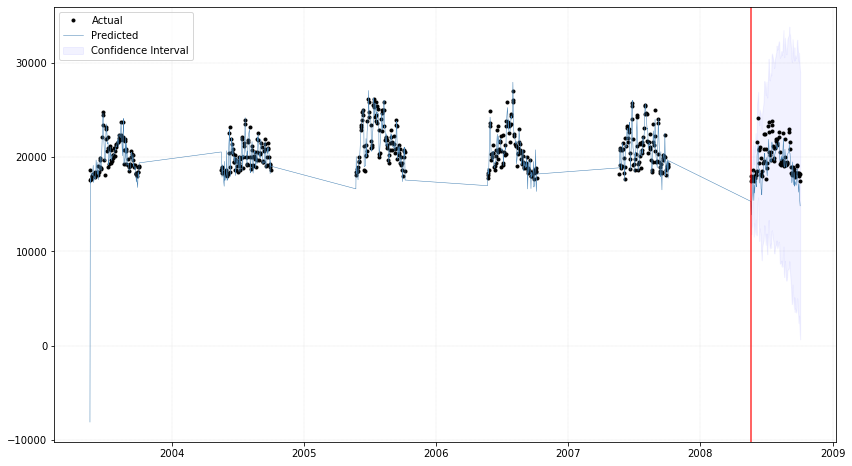

In [7]:
fig, ax = plot_prediction(pred_vals, goback_years=10)
plt.show();

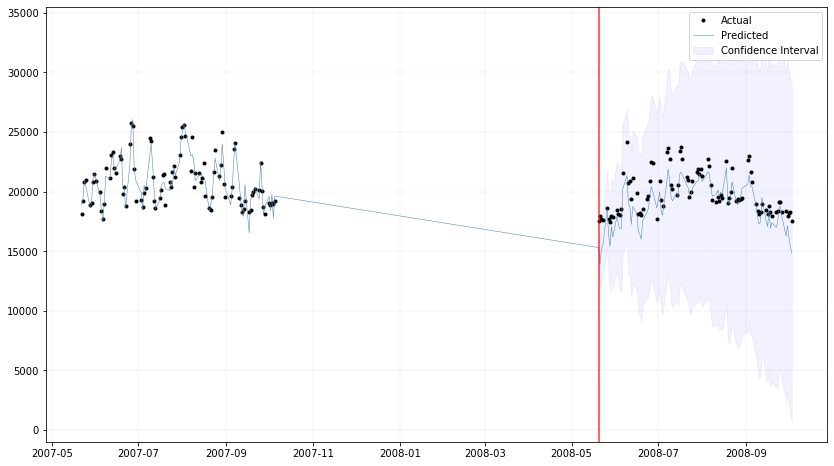

In [8]:
fig, ax = plot_prediction(pred_vals, goback_years=2)
plt.show();

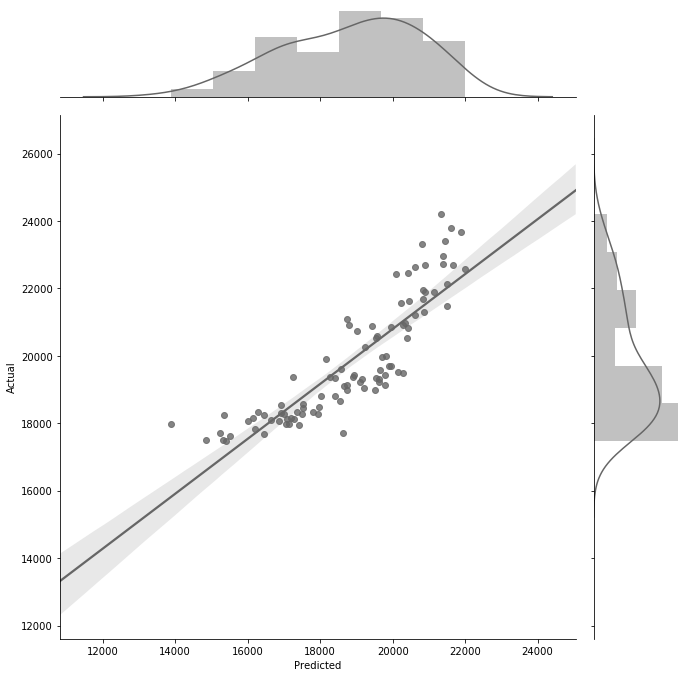

In [9]:
fig, ax = plot_joint_plot(pred_vals, goback_years=1)
plt.show();

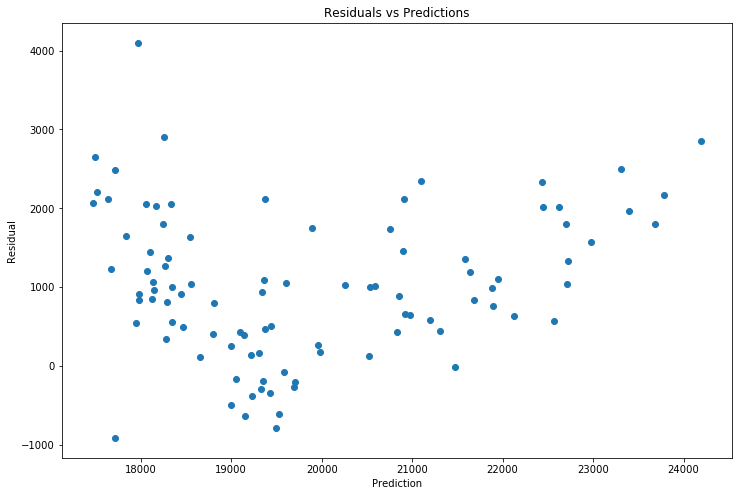

In [10]:
fig, ax = resids_vs_preds_plot(pred_vals)
plt.show()

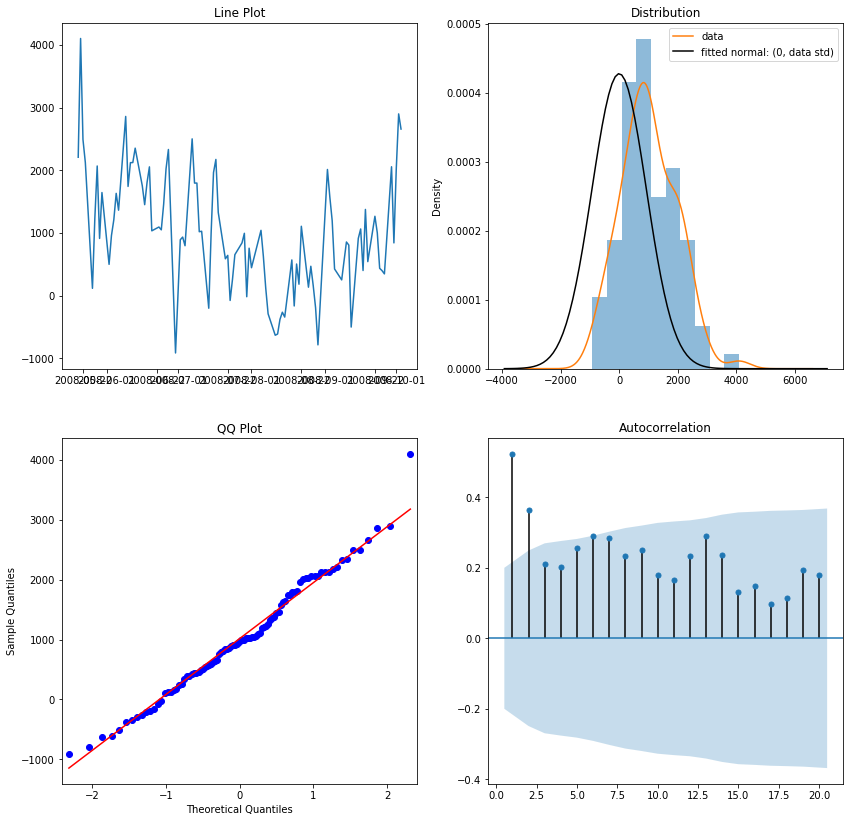

In [11]:
fig, ax = residual_plots(pred_vals)
plt.show()

In [12]:
print_residual_stats(pred_vals)

LJung Box Corr p value:		0.0
Jarque Bera Normal p value:	0.39214


In [13]:
df = save_run_results(X, n_splits, 'SARIMAX III', d, RESULTS_PATH)
df

Baseline                      Prophet                 Prophet + XGBoost       Prophet + SVR       Prophet + ExtraTreesRegressor       Prophet + KNeighborsRegressor          SARIMAX I                   SARIMAX II                  SARIMAX III                
              mae bound_precision          mae bound_precision               mae bound           mae bound                           mae bound                           mae bound          mae bound_precision          mae bound_precision          mae bound_precision
1999   785.341009             0.6   720.218501             0.8        564.413176   0.8    560.362095   0.8                    569.261791   0.8                    584.775158   0.8  1112.077920             0.4  1236.283269             0.2  1166.446318             0.2
2000   841.496643             0.8   538.393316             0.8        388.030452   0.8    362.055640   1.0                    432.848825   0.8                    424.615675   1.0   668.878294             0.8   603.228495             0.8   769.569664             0.8
2001   971.010973             0.6   730.275530             1.0        521.176514   1.0    454.831895   0.8                    469.712880   1.0                    526.795331   1.0   987.696046             1.0  1080.461134             0.8  1458.076339             0.8
2002  1120.417756             0.4   712.523997             0.4        509.309746   0.6    481.726185   0.6                    488.165615   0.4                    524.243588   0.4   823.644842             0.4   867.031741             0.4   942.186996             0.4
2003  1576.417824             0.6   938.619116             0.6        837.172955   0.4    795.189746   0.6                    824.453637   0.4                    813.178224   0.6   867.642272             0.2   919.126232             0.2   963.815242             0.2
2004  1447.394438             0.6   605.586615             0.8        635.993295   0.8    611.734944   0.8                    649.982311   0.8                    621.805963   0.8   712.122756             0.6   737.092050             0.6  3413.988221             0.6
2005  1137.307718             0.2   982.040388             0.2        768.483651   0.2    751.081354   0.2                    723.383167   0.2                    737.333514   0.2  1080.163584             0.4   880.112051             0.2  1318.535450             0.2
2006  1502.960994             0.8  1038.864989             1.0        894.626531   1.0    934.563744   1.0                    942.230578   1.0                    957.100781   1.0   872.469006             1.0   963.159329             1.0   996.059642             1.0
2007  2523.435378             0.6   660.926417             0.8        518.663409   0.8    519.714902   0.8                    504.265912   0.8                    563.747546   0.8  1086.775431             0.6   972.317453             0.6  1610.675562             0.6
2008  2433.310031             0.8   606.042829             0.6        477.396795   0.6    457.263540   0.6                    509.416763   0.6                    490.384089   0.6   957.343146             0.4  1010.807547             0.4  1128.384399             0.4